In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [3]:
from sklearn.cluster import HDBSCAN, DBSCAN
from sklearn.metrics import DistanceMetric

In [4]:
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('data.csv', header=0)

## Implementation of DBCV calculation functions
Adapted from https://github.com/christopherjenness/DBCV/blob/master/DBCV/DBCV.py to account for the precomputed Gower distance.
In addition, a correction to that code has been made. The [literature](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf) detailing the process DBCV says in Definition 4 that _l_ minimum spanning trees need to be created for the evaluation of DBCV. The referenced code only created one MST.
This also means we have to correct how the density separation is calculated. The literature offers the following:

`The Density Separation of a Pair of Clusters (DSPC) Ci
and Cj , 1 ≤ i, j ≤ l, i 6 = j, is defined as the minimum
reachability distance between the internal nodes of the
MST MRD s of clusters Ci and Cj .`

Therefore, the calculation should be to find the minimum mutual reach distance within the internal elements of two different clusters.


In [7]:
def get_class_members(x, labels, c):
    indices = np.where(labels == c)[0]
    members = x[indices]
    return members

def get_neighbor_distance(i, xDist, labels, c):
    indices = np.where(labels == c)[0]
    distanceValues = xDist[i, indices]
    return distanceValues[distanceValues != 0]

In [8]:
def core_distance(knn, cN, features):
    """
    Calculate the core distance 
    """
    if cN == 0:
        return 0.001

    if len(knn) == 0:
        return 0.001
    
    numerator = ((1/knn)**features).sum()
    core_dist = (numerator/(cN))**(-1/features)
    return core_dist

def mutual_reach_dist(ab_distance, a_member_distance, a_cN, b_member_distance, b_cN, features):
    core_dist_a = core_distance(a_member_distance, a_cN, features)
    core_dist_b = core_distance(b_member_distance, b_cN, features)
    mutual_reachability = np.max([core_dist_a, core_dist_b, ab_distance])
    return mutual_reachability
    
def reach_distance_graph(x, labels, dist):
    graph = []
    samples = x.shape[0]
    features = x.shape[1]
    # Calculate core distances
    for row in range(samples):
        graphRow = []
        class_i = clustering.labels_[row]
        members_i = get_class_members(x, labels, class_i)
        i_cN = len(members_i)
        distance_vector_i = get_neighbor_distance(row, dist, labels, class_i)

        #Calculate mutual reach distance against every other sample
        for col in range(samples):
            precomputed_distance = distances[row][col]
            class_j = clustering.labels_[col]
            members_j = get_class_members(x, labels, class_j)
            j_cN = len(members_j)
            distance_vector_j = get_neighbor_distance(col, dist, labels, class_j)
            mutual_dist = mutual_reach_dist(precomputed_distance, distance_vector_i, i_cN, distance_vector_j, j_cN, features)
            graphRow.append(mutual_dist)
        graph.append(graphRow)
    graph = np.array(graph)
    return graph
            

In [30]:
def mutual_reach_dist_mst(graph, clusters, cluster):
    # This part has been corrected from the referenced implementation.
    # Literature says it has to be l minimum spanning trees, not one single MST
    indices = np.where(clusters == cluster)[0]
    subgraph = graph[indices][:, indices]
    mst = minimum_spanning_tree(subgraph).toarray()
    return mst + np.transpose(mst)

def density_sparseness(mst):
    (internal_node_indeces, internal_node_weights) = get_internal_nodes(mst)
    return np.max(internal_node_weights)

def density_separation(graph, clusters, cluster_i, cluster_j, mst_i, mst_j):
    dist = np.inf

    # Get the MRDs corresponding to cluster i and the internal nodes for its MST
    indeces_i = np.where(clusters == cluster_i)[0]
    (internal_indices_i, iew) = get_internal_nodes(mst_i)
    # Do the same for cluster J
    indeces_j = np.where(clusters == cluster_j)[0]
    (internal_indices_j, iew) = get_internal_nodes(mst_j)

    # Find the minimum MRDs between these internal nodes
    for i in internal_indices_i:
        for j in internal_indices_j:
            mrd = graph[indeces_i[i], indeces_j[j]]
            if mrd < dist:
                dist = mrd

    return dist

def cluster_validity_index(graph, msts, labels, cluster):
    min_density_sep = np.inf
    for cluster_j in np.unique(labels):
        if cluster_j != cluster:
            cluster_density_sep = density_separation(graph, labels, cluster, cluster_j, msts[cluster], msts[cluster_j])
            if cluster_density_sep < min_density_sep:
                min_density_sep = cluster_density_sep

    cluster_density_sparseness = density_sparseness(msts[cluster])
    numerator = min_density_sep - cluster_density_sparseness
    denominator = np.max([min_density_sep, cluster_density_sparseness])
    return numerator / denominator

def get_validity_index(graph, msts, labels, samples):
    validity_index = 0
    for label in np.unique(labels):
        fraction = np.sum(labels == label) / float(samples)
        cluster_validity = cluster_validity_index(graph, msts, labels, label)
        validity_index += fraction * cluster_validity
    return validity_index

def get_internal_nodes(mst):
    # Create adjacency matrix
    is_mst_edges = (mst > 0).astype(int, copy=False)

    # Get the indeces within the MST
    internal_node_indeces = is_mst_edges.sum(axis = 0) > 1
    internal_node_indeces = np.flatnonzero(internal_node_indeces)

    internal_edge_weights = mst[internal_node_indeces][mst[internal_node_indeces].nonzero()]
    return (internal_node_indeces, internal_edge_weights)

# Data preparation

In [11]:
df = data.iloc[:, 1:]
df.drop('Degree of Control Delta', axis=1, inplace=True)
df.head()

,Persp/Ortho,Degrees of Freedom,Degrees of Control,Camera Control Varies,Has Z-Targeting,Min Screen Vert Third,Max Screen Vert Third,Min Screen Height,Max Screen Height,Camera Cuts
0,0,3,0,0,0,2,2,1,1,0
1,1,5,2,1,0,1,3,1,3,1
2,1,5,2,1,1,1,1,2,2,0
3,1,4,0,1,0,2,2,1,3,1
4,1,4,0,0,0,1,3,1,3,1


# Distance calculation

In [12]:
# Calculate the Gower distance
# https://medium.com/analytics-vidhya/concept-of-gowers-distance-and-it-s-application-using-python-b08cf6139ac2
columns = df.columns
total = DistanceMetric.get_metric('manhattan').pairwise(df[[columns[0]]])
total = total / max(np.ptp(df[columns[0]]),1)
for i in columns[1:]:
    mat = DistanceMetric.get_metric('manhattan').pairwise(df[[i]])
    mat = mat / max(np.ptp(df[i]),1)
    total += mat
    assert total[0][0] == 0
distances = total / len(columns)

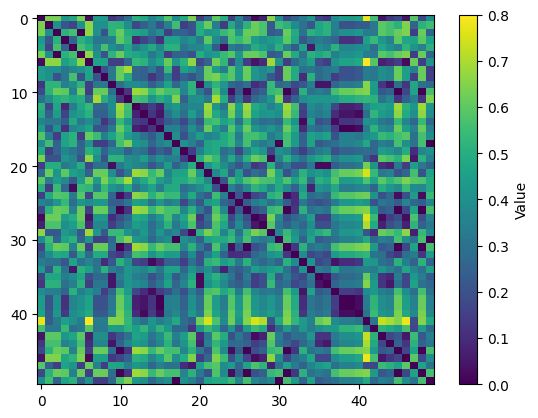

In [13]:
# Gower matrix visualization
plt.imshow(distances, cmap="viridis", aspect="auto")
plt.colorbar(label="Value")
plt.show()

In the above chart, higher values correspond to greater differences between the objects

In [14]:
distanceMatrix = pd.DataFrame(distances)
distanceMatrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.35300,0.386800,0.424800,0.380000,0.380000,0.424800,0.368000,0.374800,0.346800,0.302600,...,0.358800,0.478000,0.391600,0.337600,0.324000,0.384000,0.361600,0.362800,0.384000,0.364800
std,0.20447,0.166251,0.168384,0.156609,0.129268,0.168384,0.214647,0.148757,0.170745,0.152577,...,0.183165,0.187769,0.131826,0.182729,0.161624,0.219415,0.207859,0.153121,0.219415,0.148124
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.17500,0.227500,0.320000,0.281250,0.350000,0.320000,0.150000,0.296250,0.200000,0.225000,...,0.237500,0.335000,0.316250,0.220000,0.250000,0.205000,0.170000,0.276250,0.205000,0.270000
50%,0.39000,0.397500,0.442500,0.417500,0.387500,0.442500,0.415000,0.365000,0.320000,0.307500,...,0.375000,0.442500,0.425000,0.345000,0.332500,0.405000,0.395000,0.370000,0.405000,0.370000
75%,0.48875,0.515000,0.565000,0.473750,0.473750,0.565000,0.513750,0.443750,0.483750,0.393750,...,0.465000,0.650000,0.508750,0.460000,0.413750,0.572500,0.510000,0.465000,0.572500,0.465000
max,0.77500,0.665000,0.665000,0.600000,0.565000,0.665000,0.800000,0.695000,0.640000,0.655000,...,0.640000,0.800000,0.585000,0.730000,0.700000,0.685000,0.780000,0.615000,0.685000,0.645000


# Result Gathering

## Analyze which clustering parameters make the best grouping

In [15]:
hyperParams = [3,4,5,6,7,8,9,10]
X = df.to_numpy()

In [41]:
validities = []
for p in hyperParams:
    # Perform the clustering
    clustering = HDBSCAN(min_cluster_size=p,metric="precomputed")
    clustering.fit(distances.copy())
    print(len(np.unique(clustering.labels_)))
    print(np.unique(clustering.labels_))
    
    # Run DBCV
    # Calculate the mutual reachability distance graph. This is a complete graph
    graph = reach_distance_graph(X, clustering.labels_, distances)
    # Calculate the mutual reachability distance MSTs
    msts = {}
    for label in np.unique(clustering.labels_):
        mst = mutual_reach_dist_mst(graph, clustering.labels_, label)
        msts[label] = mst
    # Calculate the validity index [-1, 1]
    validities.append(get_validity_index(graph, msts, clustering.labels_, X.shape[0]))

10
[-1  0  1  2  3  4  5  6  7  8]
5
[-1  0  1  2  3]
4
[-1  0  1  2]
4
[-1  0  1  2]
4
[-1  0  1  2]
3
[-1  0  1]
3
[-1  0  1]
1
[-1]


C:\Users\eescu\AppData\Local\Temp\ipykernel_5760\2465679720.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


In [47]:
sum(validities[:-1]) / len(validities[:-1])

np.float64(-0.04857569693717929)

In [45]:
validities 

[np.float64(0.22927542513261828),
 np.float64(0.11186506437605032),
 np.float64(-0.06189145828747141),
 np.float64(-0.18864421401083034),
 np.float64(-0.17344775163875661),
 np.float64(-0.19961286131194922),
 np.float64(-0.05757408281991602),
 np.float64(nan)]

## Analyze each cluster in the best grouping case

Text(0, 0.5, 'DBCV Value')

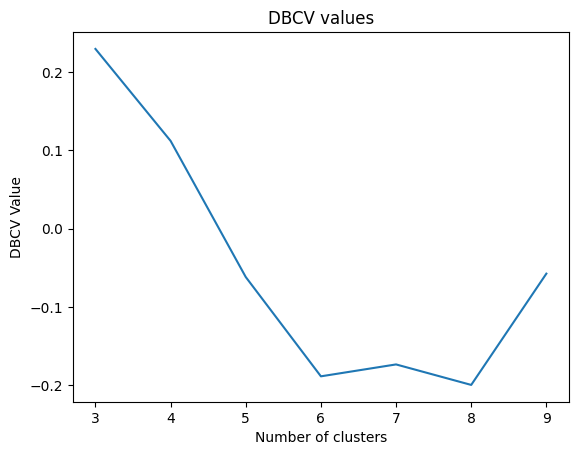

In [27]:
plt.plot(hyperParams, validities)
plt.title("DBCV values")
plt.xlabel("Number of clusters")
plt.ylabel("DBCV Value")

In [51]:
clustering = HDBSCAN(min_cluster_size=3,metric="precomputed")
clustering.fit(distances.copy())

validities = []
graph = reach_distance_graph(X, clustering.labels_, distances)
msts = {}
for label in np.unique(clustering.labels_):
    mst = mutual_reach_dist_mst(graph, clustering.labels_, label)
    msts[label] = mst
for label in np.unique(clustering.labels_):
    validities.append(cluster_validity_index(graph, msts, clustering.labels_, label))

In [37]:
data['labels'] = clustering.labels_
data['labels'].value_counts()

labels
 0    8
 1    6
 5    6
-1    6
 8    6
 2    5
 4    4
 6    3
 7    3
 3    3
Name: count, dtype: int64

Text(0, 0.5, 'Validity Value')

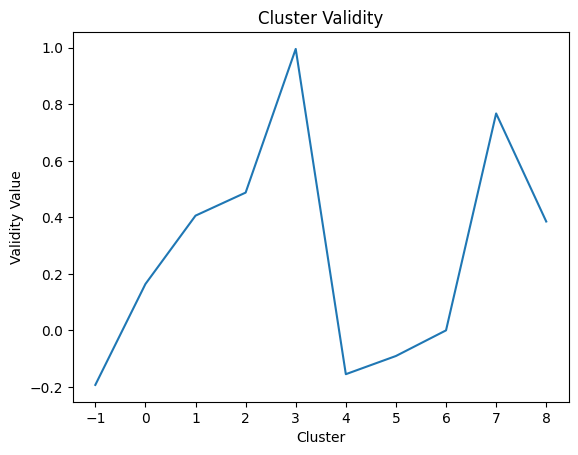

In [35]:
fig, ax = plt.subplots()
ax.plot(np.unique(clustering.labels_), validities)
ax.set_title("Cluster Validity")
ax.set_xlabel("Cluster")
ax.set_xticks(np.unique(clustering.labels_))
ax.set_ylabel("Validity Value")

Text(0, 0.5, 'Validity Value')

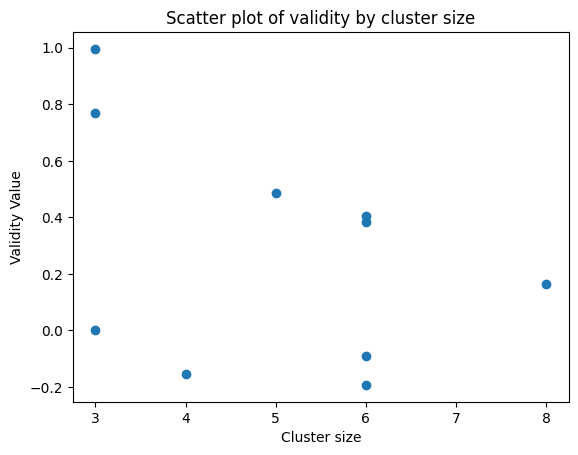

In [40]:
fig, ax = plt.subplots()
ax.scatter([6,8,6,5,3,4,6,3,3,6], validities)
ax.set_title("Scatter plot of validity by cluster size")
ax.set_xlabel("Cluster size")
ax.set_ylabel("Validity Value")

In [72]:
data.loc[data['labels']==6]

,Game,Persp/Ortho,Degrees of Freedom,Degrees of Control,Degree of Control Delta,Camera Control Varies,Has Z-Targeting,Min Screen Vert Third,Max Screen Vert Third,Min Screen Height,Max Screen Height,Camera Cuts,labels
2,God of War (Norse Era),1,5,2,3,1,1,1,1,2,2,0,6
5,Ghost of Tsushima,1,5,2,3,1,1,1,1,2,2,0,6
16,Dead Space II,1,6,3,3,1,0,1,1,2,2,0,6


In [52]:
validities

[np.float64(-0.19307202255068243),
 np.float64(0.1640012951387567),
 np.float64(0.40596666456230507),
 np.float64(0.4874915014838384),
 np.float64(0.9959183673469387),
 np.float64(-0.15510815630804162),
 np.float64(-0.09071495801849433),
 np.float64(0.0),
 np.float64(0.7675393633353219),
 np.float64(0.38521411955471374)]

In [74]:
msts[6]
distances[2, :]

array([0.64 , 0.4  , 0.   , 0.515, 0.565, 0.   , 0.665, 0.4  , 0.2  ,
       0.52 , 0.615, 0.495, 0.47 , 0.445, 0.32 , 0.4  , 0.145, 0.25 ,
       0.25 , 0.2  , 0.495, 0.415, 0.44 , 0.54 , 0.59 , 0.42 , 0.615,
       0.62 , 0.57 , 0.22 , 0.25 , 0.615, 0.49 , 0.3  , 0.515, 0.475,
       0.515, 0.345, 0.4  , 0.4  , 0.425, 0.335, 0.32 , 0.595, 0.565,
       0.615, 0.645, 0.15 , 0.615, 0.25 ])